C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Loaded 41 embeddings


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Rebuilding molecules from graph data...
Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.09.3
	BOOST: 

Error finalizing molecule: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 304 in file Code\GraphMol\

[22:22:01] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:22:01] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:22:01] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.cpp
Failed Expression: d_implicitValence > -1
****

[22:22:01] 

****
Pre-condition Violation
getNumImplicitHs() called without preceding call to calcImplicitValence()
Violation occurred on line 304 in file D:\bld\rdkit-meta_1732947298895\work\Code\GraphMol\Atom.

Saved visualization to ./visualizations/molecular_embedding_space.png


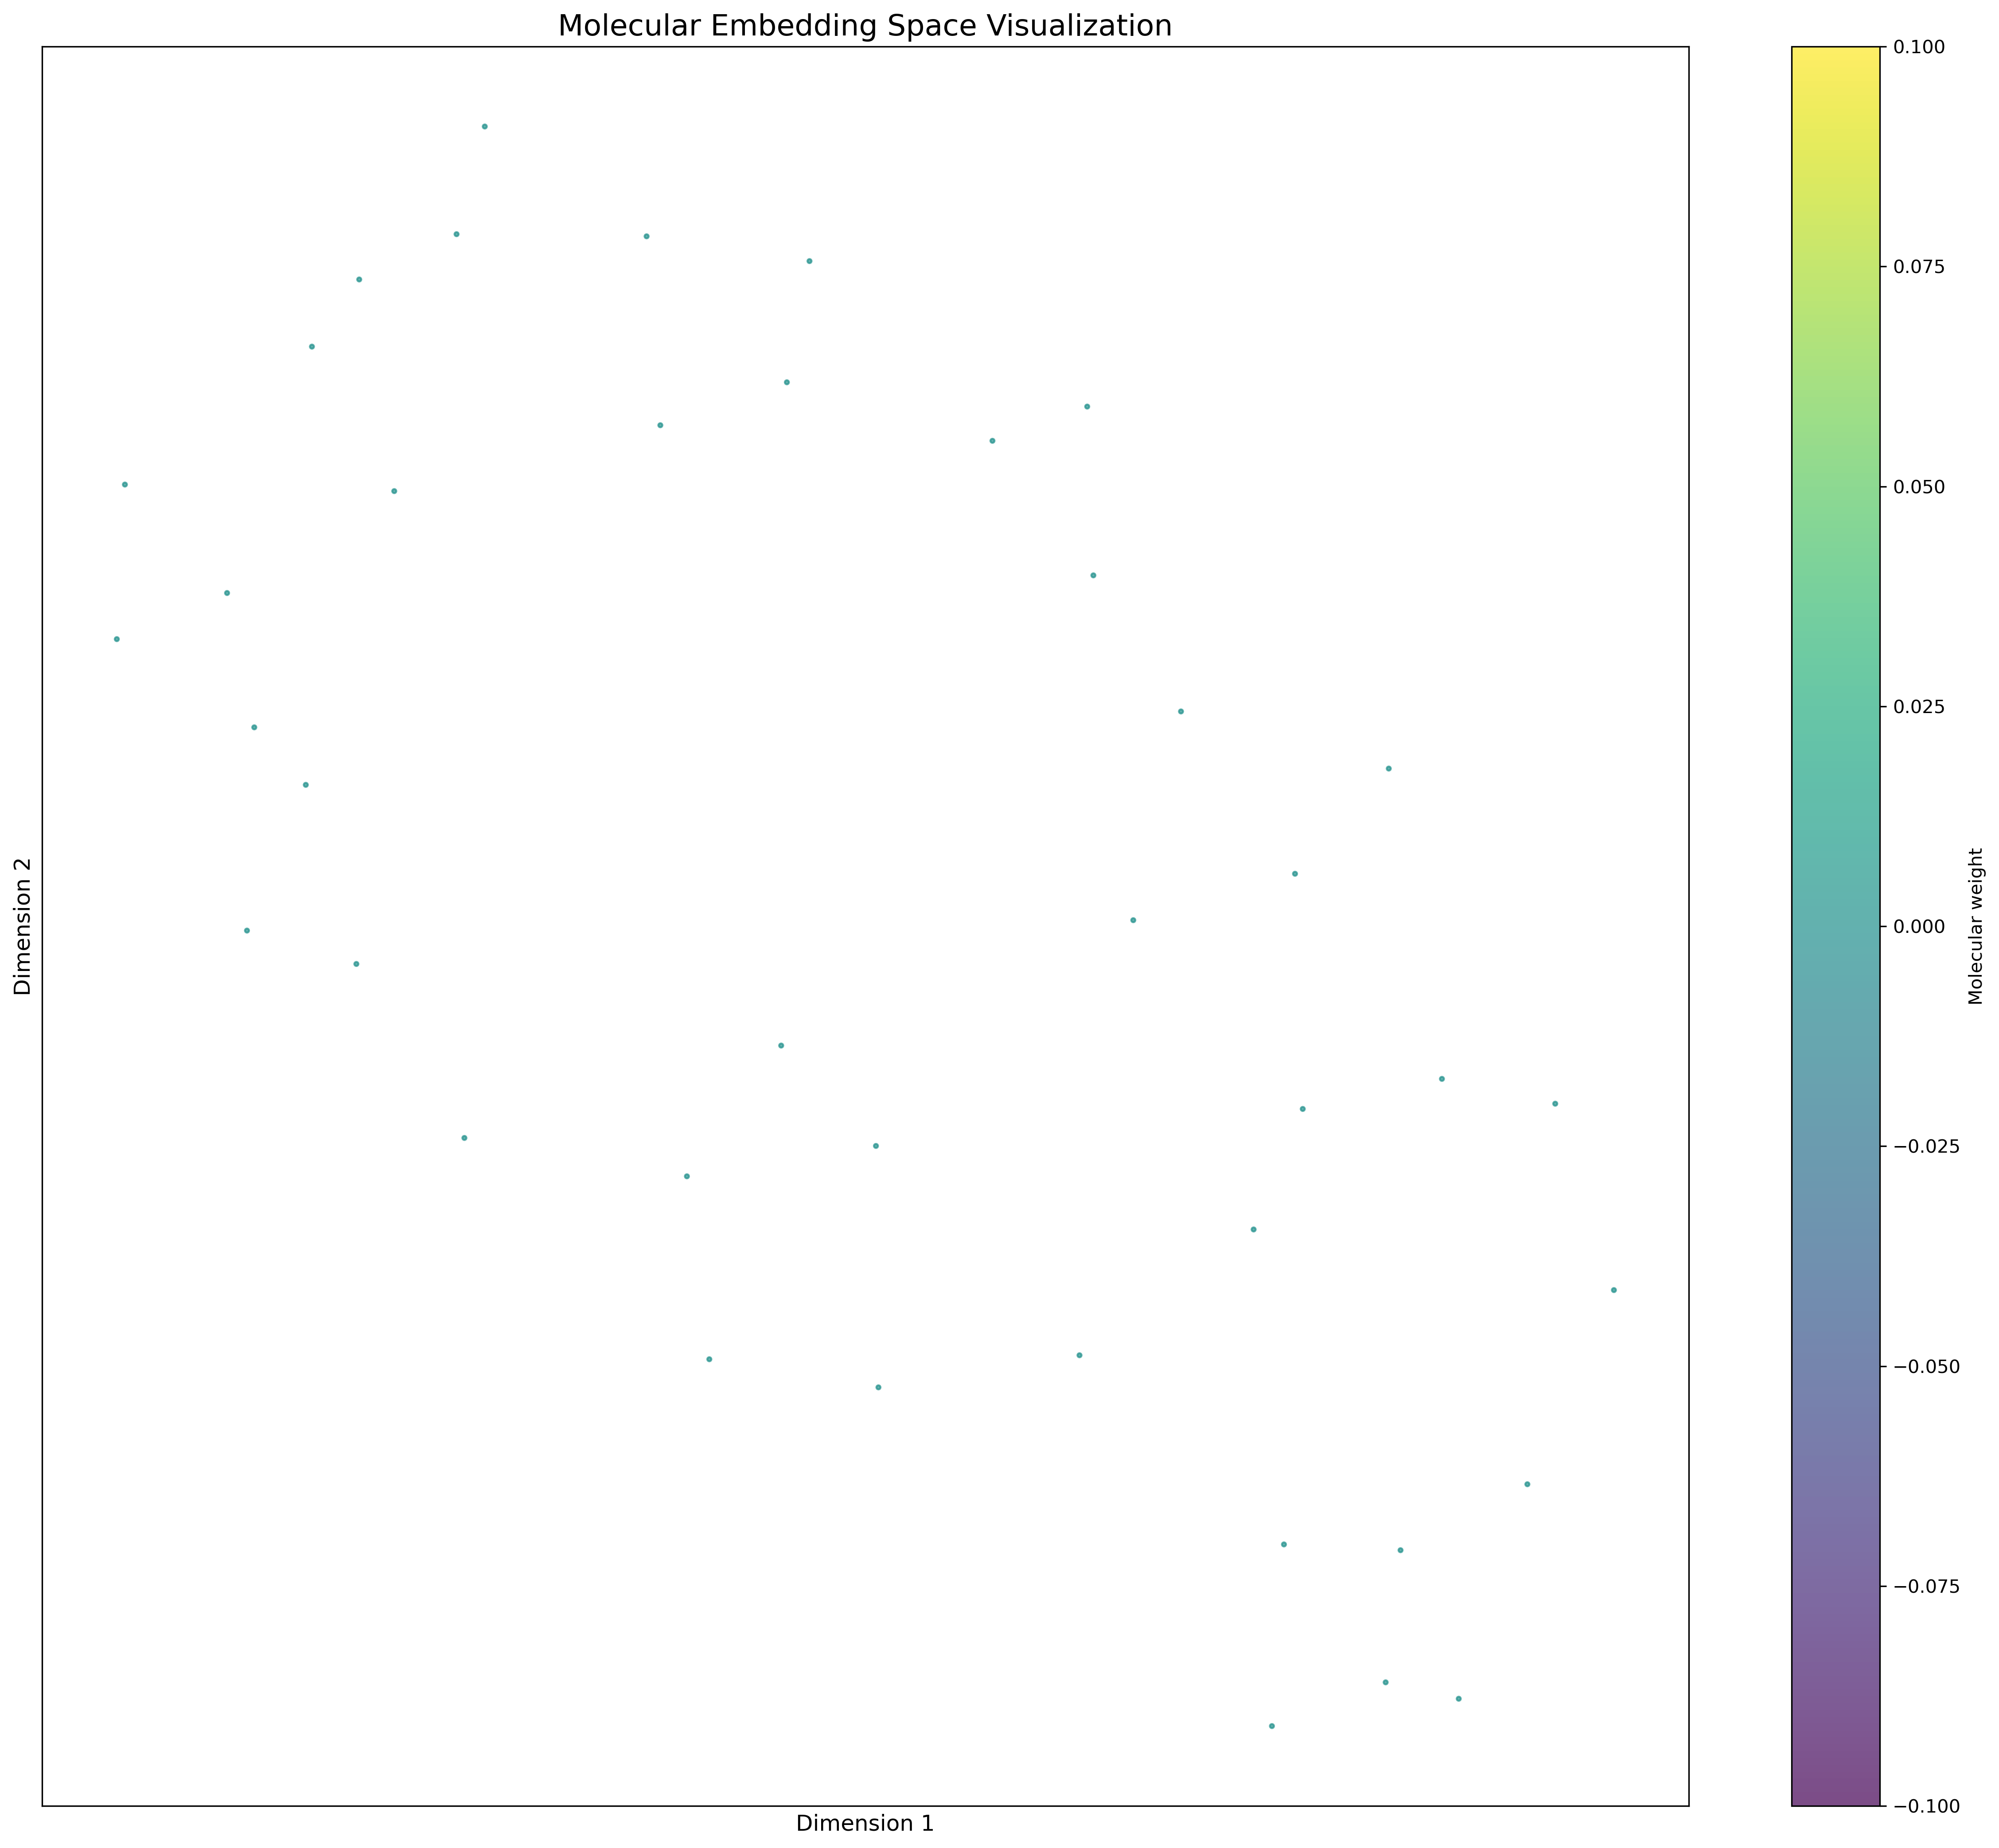

Done!


In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import io
from PIL import Image
import matplotlib.colors as mcolors
import os
from typing import List, Dict, Tuple, Optional
import torch
from torch_geometric.data import Data

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def reduce_dimensions(embeddings, method='tsne', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        reducer = PCA(n_components=n_components, random_state=42, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def rebuild_molecules_from_graph_data(molecule_data_list: List[Dict]) -> List[Optional[Chem.Mol]]:
    """Reconstruct RDKit molecules from graph data"""
    molecules = []
    
    # Maps for atom and bond features from your MolecularFeatureExtractor class
    atom_list = list(range(1, 119))
    chirality_list = [
        Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        Chem.rdchem.ChiralType.CHI_OTHER
    ]
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                atom.SetChiralTag(chirality_list[atom_features[1]])
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(Chem.Mol(mol))
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                    
                # Add the bond
                bond_type = bond_list[int(edge_attr[i][0])]
                mol.AddBond(start, end, bond_type)
                processed_edges.add((start, end))
            
            # Convert to molecule and add hydrogen
            try:
                final_mol = Chem.Mol(mol)
                final_mol = Chem.AddHs(final_mol)
                
                # Sanitize and compute 2D coordinates for visualization
                Chem.SanitizeMol(final_mol)
                AllChem.Compute2DCoords(final_mol)
                
                molecules.append(final_mol)
            except Exception as e:
                print(f"Error finalizing molecule: {e}")
                molecules.append(None)
                
        except Exception as e:
            print(f"Error rebuilding molecule: {e}")
            molecules.append(None)
    
    return molecules

def calculate_properties(molecules):
    """Calculate properties to color-code molecules"""
    properties = []
    
    for mol in molecules:
        if mol is None:
            properties.append(0)
            continue
            
        try:
            # Calculate molecular weight
            mw = Chem.Descriptors.MolWt(mol)
            properties.append(mw)
        except:
            properties.append(0)
    
    return np.array(properties)

def mol_to_image(mol, size=(200, 200), highlight_atoms=None, highlight_color=(0.9, 0.6, 0.6)):
    """Convert RDKit molecule to matplotlib-compatible image"""
    if mol is None:
        return None
        
    try:
        # Create a drawing object and set up parameters
        drawer = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
        drawer.drawOptions().addStereoAnnotation = True
        drawer.drawOptions().additionalAtomLabelPadding = 0.3
        
        # Highlight atoms if specified
        highlight_atoms = highlight_atoms or []
        highlight_bonds = []
        
        # Draw the molecule
        drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, 
                          highlightAtomColors={i: highlight_color for i in highlight_atoms},
                          highlightBonds=highlight_bonds)
        drawer.FinishDrawing()
        
        # Get PNG data
        png_data = drawer.GetDrawingText()
        
        # Convert to image
        image = Image.open(io.BytesIO(png_data))
        return image
    except Exception as e:
        print(f"Error rendering molecule: {e}")
        return None

def select_diverse_molecules(embeddings_2d, molecules, n_samples=10):
    """Select diverse molecules from the embedding space"""
    # Use a simple grid-based approach
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    
    # Create a grid
    x_bins = np.linspace(x_min, x_max, int(np.sqrt(n_samples))+1)
    y_bins = np.linspace(y_min, y_max, int(np.sqrt(n_samples))+1)
    
    selected_indices = []
    
    # Find molecules in each grid cell
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            # Find points in this cell
            mask = ((embeddings_2d[:, 0] >= x_bins[i]) & 
                    (embeddings_2d[:, 0] < x_bins[i+1]) &
                    (embeddings_2d[:, 1] >= y_bins[j]) & 
                    (embeddings_2d[:, 1] < y_bins[j+1]))
            
            indices = np.where(mask)[0]
            
            if len(indices) > 0:
                # Select a random molecule from this cell
                selected_idx = np.random.choice(indices)
                if molecules[selected_idx] is not None:
                    selected_indices.append(selected_idx)
    
    # If we didn't get enough, add more randomly
    if len(selected_indices) < n_samples:
        valid_indices = [i for i, mol in enumerate(molecules) if mol is not None]
        additional = np.random.choice(
            [i for i in valid_indices if i not in selected_indices],
            min(n_samples - len(selected_indices), len(valid_indices)),
            replace=False
        )
        selected_indices.extend(additional)
    
    return selected_indices[:n_samples]

def visualize_embeddings_with_molecules(embeddings_2d, molecules, properties, 
                                       selected_indices=None, n_samples=10,
                                       figsize=(12, 10), dpi=300,
                                       save_path=None):
    """Create a visualization of embeddings with molecule structures"""
    # Select diverse molecules if not provided
    if selected_indices is None:
        selected_indices = select_diverse_molecules(embeddings_2d, molecules, n_samples)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create a colormap
    norm = mcolors.Normalize(vmin=min(properties), vmax=max(properties))
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                        c=properties, cmap='viridis', alpha=0.7, s=5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Molecular weight')
    
    # Add molecule images
    for idx in selected_indices:
        if molecules[idx] is not None:
            img = mol_to_image(molecules[idx])
            if img is not None:
                # Convert PIL image to matplotlib image
                img_array = np.array(img)
                imagebox = OffsetImage(img_array, zoom=0.4)
                ab = AnnotationBbox(imagebox, embeddings_2d[idx], 
                                  pad=0.0, frameon=True, 
                                  bboxprops=dict(edgecolor='black', lw=1))
                ax.add_artist(ab)
    
    # Add title and labels
    ax.set_title('Molecular Embedding Space Visualization', fontsize=16)
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved visualization to {save_path}")
    
    plt.show()
    
    return fig, selected_indices

def main():
    # Create output directory
    os.makedirs('./visualizations', exist_ok=True)
    
    # Load the embeddings
    embeddings_path = './embeddings/final_embeddings_molecules_20250308_221455.pkl'  # Update with actual timestamp
    embeddings, molecule_data = load_embeddings(embeddings_path)
    
    print(f"Loaded {len(embeddings)} embeddings")
    
    # Reduce dimensions using UMAP (better for preserving global structure)
    embeddings_2d = reduce_dimensions(embeddings, method='umap', n_neighbors=15, min_dist=0.1)
    
    # Rebuild molecules from graph data
    print("Rebuilding molecules from graph data...")
    molecules = rebuild_molecules_from_graph_data(molecule_data)
    print(f"Successfully rebuilt {sum(1 for m in molecules if m is not None)} molecules")
    
    # Calculate properties for coloring
    print("Calculating molecular properties...")
    properties = calculate_properties(molecules)
    
    # Visualize embeddings with molecules
    print("Creating visualization...")
    fig, selected_indices = visualize_embeddings_with_molecules(
        embeddings_2d, 
        molecules, 
        properties,
        n_samples=12,
        figsize=(16, 14),
        save_path='./visualizations/molecular_embedding_space.png'
    )
    
    print("Done!")

if __name__ == "__main__":
    main()